In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
# download fashion MNIST datasets
(ds_train, ds_test), ds_info = tfds.load(name="fashion_mnist",
                                         split=["train", "test"],
                                         as_supervised=True,
                                         shuffle_files=True,
                                         with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteXSI8VF/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteXSI8VF/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [3]:
ds_info

tfds.core.DatasetInfo(
    name='fashion_mnist',
    full_name='fashion_mnist/3.0.1',
    description="""
    Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.
    """,
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    data_path=PosixGPath('/tmp/tmp0aggutqutfds'),
    file_format=tfrecord,
    download_size=29.45 MiB,
    dataset_size=36.42 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    = {Han Xiao a

### Preprocessing

In [4]:
# normalize images to be between 0 and 1
def normalize_images(image, label):
  return tf.cast(image, tf.float32) / 255.0, label

In [5]:
ds_train = ds_train.map(normalize_images)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits["train"].num_examples)
ds_train = ds_train.batch(32)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

In [6]:
ds_test = ds_test.map(normalize_images)
ds_test = ds_test.batch(32)
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

### Simple Autoencoder Model

In [7]:
# Simple encoder layer
class Encoder(tf.keras.layers.Layer):
  def __init__(self):
    super(Encoder, self).__init__()
    self.block = tf.keras.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=128),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Dense(units=64),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Dense(units=12),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Dense(units=4)
    ])

  def call(self, inputs):
    return self.block(inputs)


In [8]:
# Decoder layer
class Decoder(tf.keras.layers.Layer):
  def __init__(self):
    super(Decoder, self).__init__()
    # reverse of encoder block
    self.block = tf.keras.Sequential([
        tf.keras.layers.Dense(units=12),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Dense(units=64),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Dense(units=128),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Dense(units=784),
        tf.keras.layers.Activation("sigmoid"), # sigmoid used to re-normalize pixel values to between 0 and 1
        tf.keras.layers.Reshape((28, 28,-1))
    ])

  def call(self, inputs):
    return self.block(inputs)

In [9]:
# Simple autoencoder model
class Autoencoder(tf.keras.Model):
  def __init__(self):
    super(Autoencoder, self).__init__()
    self.model = tf.keras.Sequential([
        Encoder(),
        Decoder()
    ])

  def call(self, inputs):
    return self.model(inputs)

  def train_step(self, data):
    X, y = data

    with tf.GradientTape() as tape:
      decoded = self.model(X, training=True)
      loss = self.loss(X, decoded)

    training_vars = self.trainable_variables
    gradients = tape.gradient(loss, training_vars)
    self.optimizer.apply_gradients(zip(gradients, training_vars))

    results = {"loss" : loss}
    return results

  def test_step(self, data):
    X, y = data
    decoded = self.model(X, training=False)
    loss = self.loss(X, decoded)

    results = {"loss" : loss}
    return results


### Train and evaluate simple autoencoder

In [10]:
model = Autoencoder()
model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

In [11]:
model.fit(ds_train, batch_size=32, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 21s 4ms/step - loss: 0.0317
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0228
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0214
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0207
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0203
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0200
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0198
Epoch 8/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0196
Epoch 9/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0194
Epoch 10/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0193


In [12]:
model.evaluate(ds_test, batch_size=32);

313/313 [==============================] - 1s 4ms/step - loss: 0.0194


### Compare decoded images

In [13]:
test_X = []
test_y = []
for image, label in ds_test.take(1):
  test_X.append(image)
  test_y.append(model.model(image, training=False))

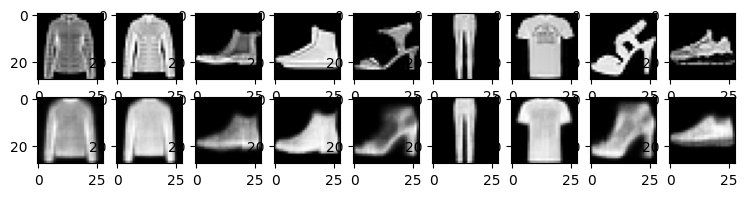

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 2))
plt.gray()
for i, item in enumerate(test_X[0]):
    if i >= 9: break
    plt.subplot(2, 9, i+1)
    # item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
    # item: 1, 28, 28
    plt.imshow(item)

for i, item in enumerate(test_y[0]):
    if i >= 9: break
    plt.subplot(2, 9, 9+i+1) # row_length + i + 1
    # item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
    # item: 1, 28, 28
    plt.imshow(item)

### Convolutional Autoencoder Model

In [21]:
# CNN encoder layer
class ConvEncoder(tf.keras.layers.Layer):
  def __init__(self):
    super(ConvEncoder, self).__init__()
    self.block = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=2, padding="same"),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding="same"),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Conv2D(filters=64, kernel_size=7)
    ])

  def call(self, inputs):
    return self.block(inputs)

In [22]:
# CNN decoder layer
class ConvDecoder(tf.keras.layers.Layer):
  def __init__(self):
    super(ConvDecoder, self).__init__()
    self.block = tf.keras.Sequential([
        tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=7),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding="same"),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=2, padding="same"),
        tf.keras.layers.Activation("sigmoid")
    ])

  def call(self, inputs):
    return self.block(inputs)

In [23]:
# Convolutional autoencoder model
class ConvAutoencoder(tf.keras.Model):
  def __init__(self):
    super(ConvAutoencoder, self).__init__()
    self.model = tf.keras.Sequential([
        ConvEncoder(),
        ConvDecoder()
    ])

  def call(self, inputs):
    return self.model(inputs)

  def train_step(self, data):
    X, y = data

    with tf.GradientTape() as tape:
      decoded = self.model(X, training=True)
      loss = self.loss(X, decoded)

    training_vars = self.trainable_variables
    gradients = tape.gradient(loss, training_vars)
    self.optimizer.apply_gradients(zip(gradients, training_vars))

    results = {"loss" : loss}
    return results

  def test_step(self, data):
    X, y = data
    decoded = self.model(X, training=False)
    loss = self.loss(X, decoded)

    results = {"loss" : loss}
    return results

### Train and evaluate simple autoencoder

In [25]:
model = ConvAutoencoder()
model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

In [26]:
model.fit(ds_train, batch_size=32, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 16s 4ms/step - loss: 0.0215
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0101
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0082
Epoch 4/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0073
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0068
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0065
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0063
Epoch 8/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0062
Epoch 9/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0060
Epoch 10/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0059


In [27]:
model.evaluate(ds_test, batch_size=32);

313/313 [==============================] - 1s 4ms/step - loss: 0.0060


### Compare decoded images

In [28]:
test_X = []
test_y = []
for image, label in ds_test.take(1):
  test_X.append(image)
  test_y.append(model.model(image, training=False))

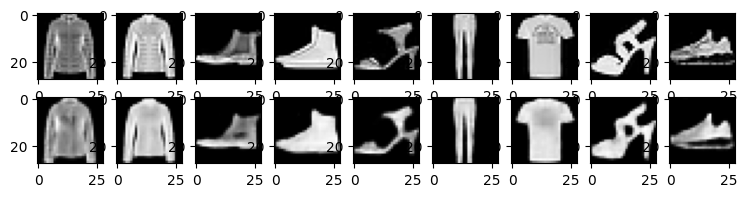

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 2))
plt.gray()
for i, item in enumerate(test_X[0]):
    if i >= 9: break
    plt.subplot(2, 9, i+1)
    plt.imshow(item)

for i, item in enumerate(test_y[0]):
    if i >= 9: break
    plt.subplot(2, 9, 9+i+1) # row_length + i + 1
    plt.imshow(item)